In [1]:
# Necessary imports and setup
%matplotlib inline

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import candl
import candl.interface
import candl.tools
import candl.plots

candl.plots.set_plot_style()# Set the plot style (font sizes, tick widths, ...)

import candl_data

import blackjax
from datetime import date

from tqdm.notebook import tqdm

from copy import deepcopy

from getdist import MCSamples
import matplotlib.pyplot as plt

# Disable LaTeX rendering (LaTeX not installed)
plt.rcParams['text.usetex'] = False



I0000 00:00:1762962248.572829 2999634 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Initialise the ACT DR4 CMB-only TTTEEE likelihood
candl_like = candl.Like(candl_data.ACT_DR4_TTTEEE)


Successfully initialised candl likelihood 'ACT DR4 TT/TE/EE (Choi et al. 2020, Aiola et al. 2020)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/home/ljb200/git/jax-cmb-pipeline/.venv/lib/python3.11/site-packages/candl_data/ACT_DR4_CMB_only_v0/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT dxd       (40 bins, bin centres spanning ell = 600.3 - 4123.0)
TE dxd       (45 bins, bin centres spanning ell = 350.5 - 4123.0)
EE dxd       (45 bins, bin centres spanning ell = 350.3 - 4122.9)
TT wxw       (40 bins, bin centres spanning ell = 600.4 - 4122.3)
TE wxw       (45 bins, bin centres spanning ell = 350.5 - 4122.4)
EE wxw       (45 bins, bin centres spanning ell = 350.4 - 4122.4)
--------------------------------------------------------------------------------
A data model consisting of 1 transformations has been initialised.
The following transformations will be

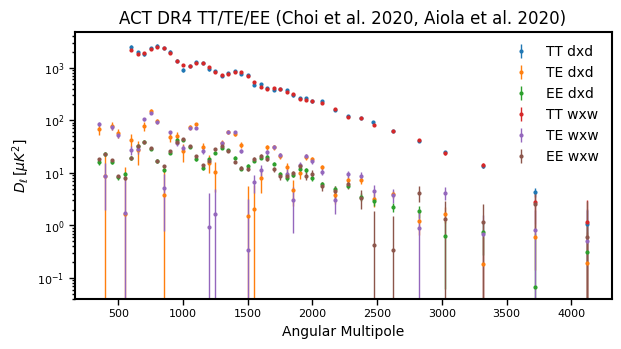

In [3]:
# Plot the band powers!
# This is a simple plotting stript that accesses candl_like.data_bandpowers
# 'd' and 'w' denote deep and wide fields respectively
plt.close()
candl.plots.plot_band_powers(candl_like, colour_by_spec_type=False)
plt.show()

In [ ]:
# Grab a theory calculator and initialise it
# Here, we use our differentiable, high-precision CosmoPower models
# These take care of the step of moving from cosmological parameters to theory Cls
cp_emulator_filenames = {"TT": "cmb_lcdm_spt_TT_NN.pkl",
                         "TE": "cmb_lcdm_spt_TE_PCAplusNN.pkl",
                         "EE": "cmb_lcdm_spt_EE_NN.pkl"}
pars_to_theory_specs = candl.interface.get_CosmoPowerJAX_pars_to_theory_specs_func(cp_emulator_filenames)

# Define fiducial parameters - cosmological ones by hand
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054,
            'yp': 1.0}

# Here, we grab a function that moves from parameters to logl all in one step.
# This is a light wrapper that combines our theory calculator (CosmoPower) and our likelihood.
# There's a bit of glue in-between, which crops the spectra to the right ell range.
# We also grab the derivative and the Hessian
like = jax.jit(candl.tools.get_params_to_logl_func(candl_like, pars_to_theory_specs))
like_deriv = jax.jit(jax.jacrev(like))
like_hessian = jax.jit(jax.hessian(like))


2025-11-12 15:44:16.047238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# We want to minimise all parameters - cosmological ones and nuisance parameters
pars_for_min = ["H0", "ombh2", "omch2", "ns", "logA", "tau"] + candl_like.required_nuisance_parameters

# Set the fiducial starting point
starting_pars = deepcopy(fid_pars)

# Step through minimiser
newton_points, newton_par_covs = candl.tools.newton_raphson_minimiser(like_deriv = like_deriv,# Derivative function
                                                                 like_hess = like_hessian,# Hessian function
                                                                 starting_pars = starting_pars,# Start point
                                                                 pars_for_min = pars_for_min,# Which parameters to minimise
                                                                 N_newton = 20,# How many steps to take
                                                                 show_progress = True)# Show loading bars

# Grab expected size of parameter errors based on Fisher matrix
par_scales = {}
for i, p in enumerate(pars_for_min):
    par_scales[p] = jnp.sqrt(newton_par_covs[-1][i,i])

# Helper functions to move from regular units to N(0,1)
def transform_to_zero_mean_unit_var(par_dict):
    new_par_dict = {}
    for p in par_dict:
        if p in fid_pars and p in par_scales:
            new_par_dict[p] = jnp.array((par_dict[p] - fid_pars[p])/par_scales[p], float)
    return new_par_dict

def transform_from_zero_mean_unit_var(par_dict):
    new_par_dict = {}
    for p in par_dict:
        if p in fid_pars and p in par_scales:
            new_par_dict[p] = jnp.array(fid_pars[p] + par_dict[p]*par_scales[p], float)
    return new_par_dict

# Here, we grab a function that moves from normed parameters to logl all in one step.
like_normed = jax.jit(lambda p: -1.0*like(transform_from_zero_mean_unit_var(p)))# ADAM uses a different sign convention (logl to be positive)
like_normed_deriv = jax.jit(jax.jacrev(like_normed))

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
# Wrap the likelihood in a function that takes in a vector of parameters (defined by pars_for_min)
@jax.jit
def like_normed_vec(input_vec):
    par_dict = {pars_for_min[i]: input_vec[i] for i in range(len(pars_for_min))}
    nenormed_par_dict = transform_from_zero_mean_unit_var(par_dict)
    return like(nenormed_par_dict)

# Define the inference loop
# This code is taken from the BlackJAX tutorial
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states



In [7]:
# Run NUTS chains! This takes about a minute.
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))# grab random number for starting point
nuts = blackjax.nuts(like_normed_vec, step_size=0.1, inverse_mass_matrix=np.ones(len(pars_for_min)))
initial_state = nuts.init(np.zeros(len(pars_for_min)))
states = inference_loop(rng_key,
                        nuts.step,
                        initial_state,
                        100)# Number of desired samples



In [8]:
# Restore units to samples and convert to a GetDist MCSamples object
fid_pars_vec = np.array([fid_pars[p] for p in pars_for_min])
def denorm_pars(pars):
    return pars*np.sqrt(np.diag(newton_par_covs[-1]))+fid_pars_vec
NUTS_samples = jnp.apply_along_axis(denorm_pars, 1, states.position)

gd_samples_NUTS = MCSamples(samples = np.array(NUTS_samples),
                            names = pars_for_min,
                            labels = [candl.plots.PAR_LABEL_DICT[p] if p in candl.plots.PAR_LABEL_DICT else p for p in pars_for_min],
                            label='BlackJAX NUTS')
gd_samples_NUTS.loglikes = np.zeros(100)# BlackJAX doesn't return logl values, we set these to zero here

Removed no burn in


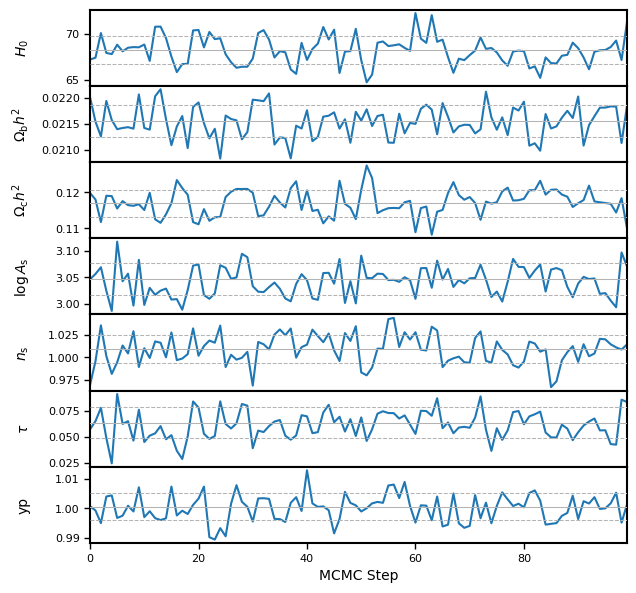

In [10]:
# Plot the NUTS samples!
# These are much less correlated than the MH samples from the traditional tutorial.
plt.close()
fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples_NUTS,# samples to plot
                                            list(fid_pars.keys()),# parameters to plot
                                            newton_points[-1],# best-fit point
                                            newton_par_covs[-1],# Fisher matrix from the Newton minimiser
                                            pars_for_min,# order of parameters in covariance matrix
                                            show_logl=False)# Order of paramters in the Fisher matrix
plt.show()

